In [1]:
import matplotlib.pyplot as plt
from cointegration.funcs import * 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller as adf


In [2]:
ticker = 'PMSB'
share = pd.read_csv(f'../data/shares_data/companies/{ticker}.csv')
pref = pd.read_csv(f'../data/shares_data/companies_pref/{ticker}P.csv')

# matching
share, pref = match_ts(share, pref)

# in sample
cut = int(2* len(share.close)/3)
share_sample = share.close[:cut]
pref_sample = pref.close[:cut]
time_sample = np.linspace(0, 5*2/3, cut)

# out of sample
share_check = share.close[cut:]
pref_check = pref.close[cut:]
time_check = np.linspace(5*2/3, 5, len(share) - cut)

Time Series1:  62.6% is missing (106871 ==> 39995)
Time Series2:  61.5% is missing (103892 ==> 39995)


Coefs: [17.33093726 -4.6550004   0.98089672]


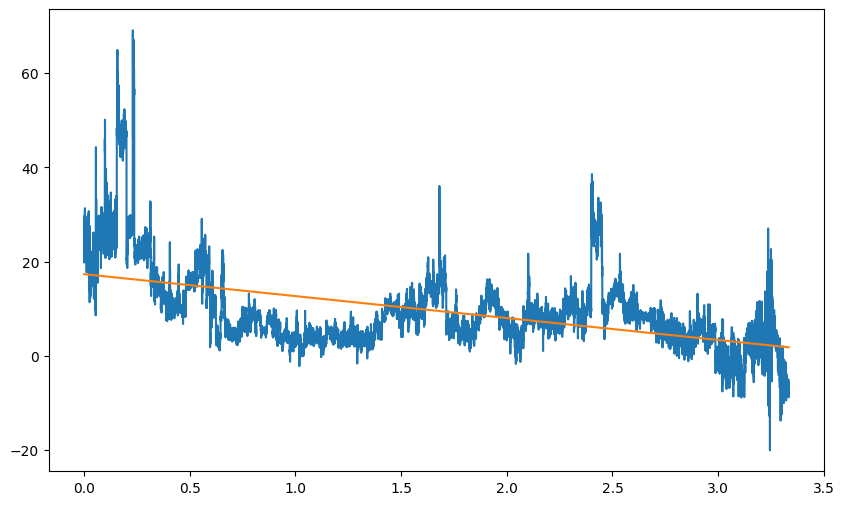

(-4.629958433007561,
 0.00011370557691209067,
 8,
 2658,
 {'1%': -3.4328126134378745,
  '5%': -2.8626279979662965,
  '10%': -2.567349178634173},
 12221.041874362041)

In [3]:
# regression with trend
A = np.array((np.ones_like(time_sample), time_sample, share_sample))
lp = pref_sample

res = np.linalg.lstsq(A.T, lp, rcond=None)
print(f'Coefs: {res[0]}')
a, t, b = res[0]

err = pref_sample - b*share_sample - t*time_sample - a

# visualising
plt.figure(figsize=(10,6))
plt.plot(time_sample, pref_sample - b*share_sample)
plt.plot(time_sample, time_sample*t + a)
plt.show()

adf(err[::10])

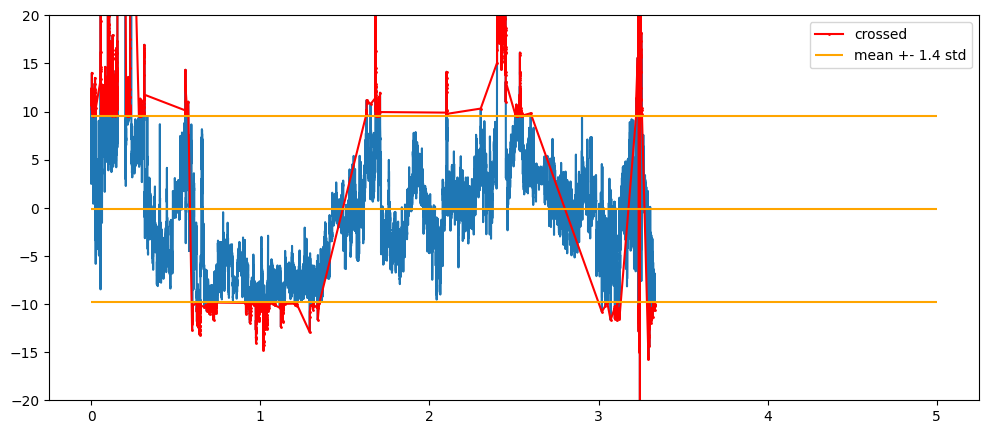

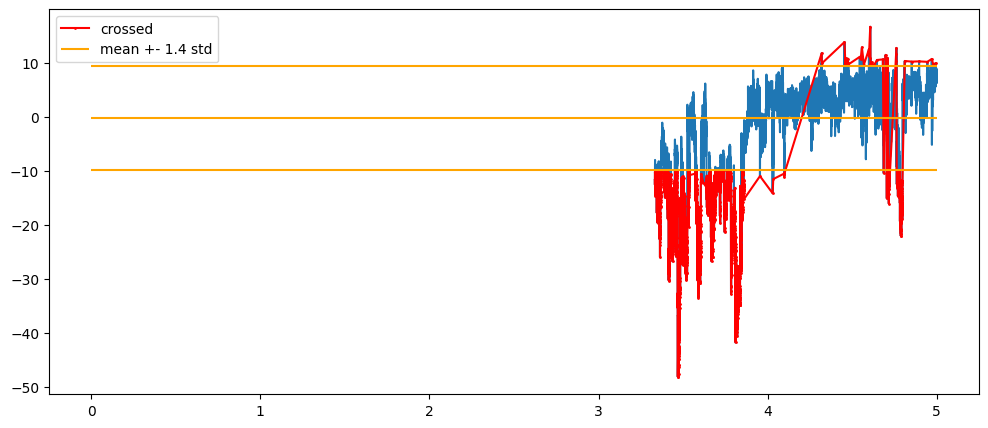

In [6]:
# in sample bands indicator
df = pd.DataFrame()
df['err'] = err
df['time'] = time_sample

# calculating bands params
clipped = df.clip(df['err'].quantile(0.02), df['err'].quantile(0.98), axis=1)
mean = clipped['err'].mean()
std = clipped['err'].std()
mul = 1.4
cross = df.loc[(df['err'] > mean+std*mul) | (df['err'] < mean-std*mul)]

plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['err'])
plt.plot(cross['time'], cross['err'], label='crossed', color='red', marker='o',markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.legend()
plt.ylim(-20, 20)
plt.show()

# out of sample bands indicator with in sample bands params
check_df = pd.DataFrame()
err_check = pref_check - b*share_check - t*time_check - a
check_df['err'] = err_check
check_df['time'] = time_check
cross_check = check_df.loc[(check_df['err'] > mean+std*mul) | (check_df['err'] < mean-std*mul)]

plt.figure(figsize=(12, 5))
plt.plot(check_df['time'], check_df['err'])
plt.plot(cross_check['time'], cross_check['err'], label='crossed', color='red', marker='o', markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.plot()
plt.legend()